<a href="https://colab.research.google.com/github/StevenMElliott/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

**This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. **It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

Data Science is the search for "Generalizable Truth"

What are some omitted variables that may be confounding findings.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10)# sets random seem for repoducabilty

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, True)
print(example_user)

User(purchased=False, time_on_site=12, mobile=True)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600) # how long are they are on site
  purchased = random.random() < 0.1 + (time_on_site / 1500) #did they purchse? For ever 15 seconds on site, their likelihood of purchse increase 1%
  users.append(User(purchased, time_on_site, False)) #False because desktop not mobile
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500) #higher initial likelyhood of buying, but less time
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users) #generates df with User Tuples
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [5]:
import numpy as np
user_data.describe(exclude=[np.number])

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,644,750


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])
#crosstab, of if they purchase and how long they spent

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,8.340271367612646,8.606832008318156,9.218381144065109,10.058796842584638,10.05973343102422,10.098880952488393,10.269710128673584,10.624743380825596,10.775511794102913,10.837439718435094,10.847332077574741,11.300954145638592,11.66995174259849,11.675545744100827,11.782873882183889,11.841426573214946,12.392535053460403,12.40665438918597,12.92898208568828,12.955059196515535,12.996416835255978,13.382120427301592,13.54511635197098,13.934746202094221,14.137459282045185,15.38873657245532,16.922971203004536,17.353027809843624,17.447706834056127,17.662245360895042,...,482.6472145022762,485.9266783851125,486.4774281431866,489.8595383008188,492.78513492217877,495.15954119502254,497.0189957498146,499.3596843687688,502.23256501573536,503.5096132803155,510.3106040801197,513.7199567827874,514.524187056424,516.4726132592837,517.4950119989117,518.7549370475441,523.0318717844676,524.0890952881243,541.9178996100884,547.2149524114925,553.3795732755347,563.7377598676529,565.1913401235421,568.9570603645093,569.1394152918596,570.4001379889107,571.1747962145259,576.1168783345762,576.2458375079051,581.5998993123494,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1


In [0]:
#!pip freeze #freeze state of environment, what versions exist at time of freeze
#Pd 0.24.2
#!pip install pandas==0.23.4

In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [9]:
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,0.728873,0.622837,0.559603,0.803922,0.714286,0.53125
True,0.271127,0.377163,0.440397,0.196078,0.285714,0.46875


In [11]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

In [13]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
                rownames=['device'],
                colnames=['purchased', 'time on site'],
                normalize='index')
ct

purchased               False        ...                      True 
time on site (4.573, 104.291]        ...         (500.782, 599.904]
device                               ...                           
False                   0.132        ...                       0.06
True                    0.232        ...                       0.00

[2 rows x 12 columns]

In [14]:
ct.iloc[0][6] #0th row, 6th column

0.02

In [0]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)

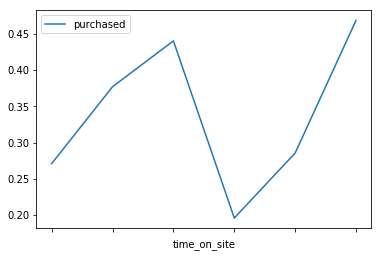

In [16]:
pt.plot.line();

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                normalize='columns')

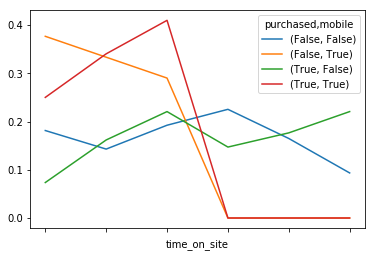

In [18]:
ct.plot();

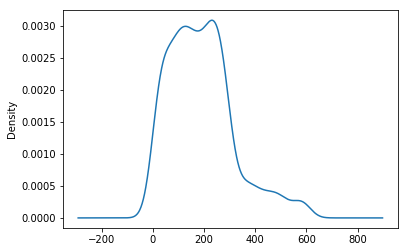

In [19]:
user_data['time_on_site'].plot.density();

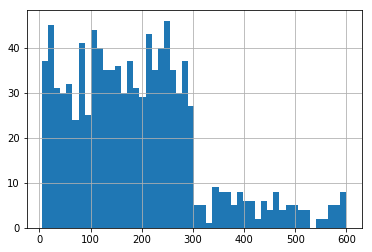

In [20]:
user_data['time_on_site'].hist(bins=50);

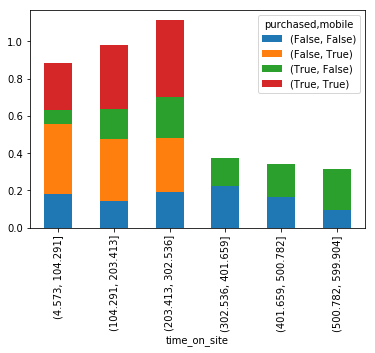

In [21]:
(ct.plot(kind='bar', stacked=True));

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv")

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df.copy(), random_state=0)

train.shape, test.shape

((900, 4), (300, 4))

In [35]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


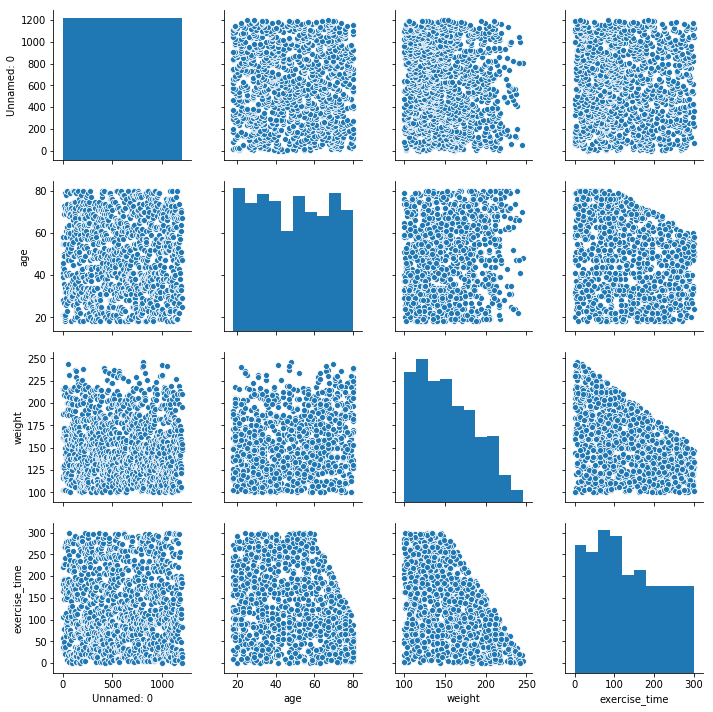

In [40]:
import seaborn as sns
graph = sns.pairplot(df)

Based on looking at the above plots, there is a correlation between
excercise time and weight. There is also a lesser corrlation between
age and weight/exercise time. As people get older, they wiegh more
and exercise less.

In [61]:
age_bins = pd.cut(train['age'], 3)
weight_bins = pd.cut(train['weight'], 15)
time_bins = pd.cut(train['exercise_time'], 6)
pd.crosstab(weight_bins, time_bins)
#This cross tab, mirrors weight, time plot.

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
weight,,,,,,
"(99.854, 109.733]",10,11,9,13,13,17
"(109.733, 119.467]",9,11,19,15,11,22
"(119.467, 129.2]",11,12,18,16,21,27
"(129.2, 138.933]",7,11,9,15,20,19
"(138.933, 148.667]",15,18,5,24,14,16
"(148.667, 158.4]",10,16,18,9,18,11
"(158.4, 168.133]",9,23,14,8,10,4
"(168.133, 177.867]",12,17,13,11,7,0
"(177.867, 187.6]",18,17,17,15,1,0


In [70]:
ct = pd.crosstab(time_bins, [weight_bins, age_bins],
                normalize='columns')

# ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
#                 normalize='columns')
ct

weight         (99.854, 109.733]       ...        (236.267, 246.0]
age             (17.938, 38.667]       ...          (59.333, 80.0]
exercise_time                          ...                        
(-0.3, 50.0]            0.000000       ...                     1.0
(50.0, 100.0]           0.068966       ...                     0.0
(100.0, 150.0]          0.137931       ...                     0.0
(150.0, 200.0]          0.275862       ...                     0.0
(200.0, 250.0]          0.241379       ...                     0.0
(250.0, 300.0]          0.275862       ...                     0.0

[6 rows x 44 columns]

In [0]:
.plot();

#make a model that

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)